<a href="https://colab.research.google.com/github/109368018yumin/project/blob/main/Remove_RF_LR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
#########remove outliers###########
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive 

drive.mount('/content/gdrive')
%cd /content/gdrive/MyDrive/dissertation/UIC_data/output/
df_all = pd.read_csv("NORMAL_BLOOD_PRESSURE2.csv") 

num_features = ['PPG_DBP_Time_plus_PPG_Amplitude_time', 'PTT', 'PPG_DBP_Time_divide_PTT','PPG_one_wave_time', 'PPG_DBP_Time','PPG_Amplitude_time','PTT_DBP_percent']
target = ['SBP','DBP']

df = df_all[num_features + target]
df.head()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/dissertation/UIC_data/output


,PPG_DBP_Time_plus_PPG_Amplitude_time,PTT,PPG_DBP_Time_divide_PTT,PPG_one_wave_time,PPG_DBP_Time,PPG_Amplitude_time,PTT_DBP_percent,SBP,DBP
0,0.488,0.224,0.144,0.496,0.368,0.128,0.608696,118.35,66.135
1,0.496,0.232,0.136,0.488,0.368,0.120,0.630435,119.57,66.135
2,0.488,0.224,0.136,0.480,0.360,0.120,0.622222,118.98,66.184
3,0.480,0.216,0.136,0.472,0.352,0.120,0.613636,119.57,66.623
4,0.480,0.224,0.136,0.488,0.360,0.128,0.622222,118.59,62.569


In [25]:
df.describe()

,PPG_DBP_Time_plus_PPG_Amplitude_time,PTT,PPG_DBP_Time_divide_PTT,PPG_one_wave_time,PPG_DBP_Time,PPG_Amplitude_time,PTT_DBP_percent,SBP,DBP
count,3687.000000,3687.000000,3687.000000,3687.000000,3687.000000,3687.000000,3687.000000,3687.000000,3687.000000
mean,0.675693,0.287366,0.221924,0.673523,0.509290,0.164233,0.576388,107.382178,68.598327
std,0.109461,0.032450,0.082558,0.112638,0.085036,0.057716,0.095768,8.087713,7.143108
min,0.376000,0.152000,0.032000,0.384000,0.240000,0.096000,0.181818,90.107000,60.020000
25%,0.584000,0.272000,0.152000,0.584000,0.432000,0.136000,0.520548,99.935000,61.934000
50%,0.672000,0.288000,0.216000,0.672000,0.528000,0.144000,0.575758,106.500000,65.305000
75%,0.696000,0.312000,0.272000,0.696000,0.552000,0.176000,0.647059,115.420000,76.734000
max,1.320000,0.408000,0.936000,1.456000,1.144000,1.104000,0.918367,119.910000,79.948000


In [26]:
ft = ['PPG_DBP_Time_plus_PPG_Amplitude_time', 'PTT', 'PPG_DBP_Time_divide_PTT','PPG_one_wave_time', 'PPG_DBP_Time','PPG_Amplitude_time','PTT_DBP_percent']
remove = set()

for x in ft:
  q25, q75 = np.percentile(df.loc[:,x], [25, 75])
  n=1.5  #1.5倍四分位距
  #IQR=Q3-Q1
  intra = q75 - q25
  # outlier = Q3 + n*IQR 
  max = q75 + intra *n
  # outlier = Q1 - n*IQR 
  min = q25 - intra *n
  
  transform_data1 = df.loc[df[x] < min, x].index
  transform_data2 = df.loc[df[x] > max, x].index
  remove = remove.union(transform_data1).union(transform_data2)
  
df.drop(remove, inplace=True)
df.to_csv('removed_data.csv')
#########remove outliers###########

In [6]:
!pip install rfpimp

  Created wheel for rfpimp: filename=rfpimp-1.3.7-py3-none-any.whl size=10669 sha256=1b103b477670242a2543d4656ac8530b8986380cca3f27bf87c4a63a44812cd4
  Stored in directory: /root/.cache/pip/wheels/ad/48/d9/21fc62fbeff405425b0d5dd8b0354576cdb62ac97f6b11d1ef
Successfully built rfpimp


In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df_all = pd.read_csv("removed_data.csv") 

num_features = ['PPG_DBP_Time_plus_PPG_Amplitude_time', 'PTT', 'PPG_DBP_Time_divide_PTT','PPG_one_wave_time', 'PPG_DBP_Time','PPG_Amplitude_time','PTT_DBP_percent']
target = ['SBP','DBP']

df = df_all[num_features + target]
df.head()

,PPG_DBP_Time_plus_PPG_Amplitude_time,PTT,PPG_DBP_Time_divide_PTT,PPG_one_wave_time,PPG_DBP_Time,PPG_Amplitude_time,PTT_DBP_percent,SBP,DBP
0,0.488,0.224,0.144,0.496,0.368,0.128,0.608696,118.35,66.135
1,0.496,0.232,0.136,0.488,0.368,0.120,0.630435,119.57,66.135
2,0.488,0.224,0.136,0.480,0.360,0.120,0.622222,118.98,66.184
3,0.480,0.216,0.136,0.472,0.352,0.120,0.613636,119.57,66.623
4,0.480,0.224,0.136,0.488,0.360,0.128,0.622222,118.59,62.569


In [28]:
df.describe()

,PPG_DBP_Time_plus_PPG_Amplitude_time,PTT,PPG_DBP_Time_divide_PTT,PPG_one_wave_time,PPG_DBP_Time,PPG_Amplitude_time,PTT_DBP_percent,SBP,DBP
count,3092.000000,3092.000000,3092.000000,3092.000000,3092.000000,3092.000000,3092.000000,3092.000000,3092.000000
mean,0.648132,0.288386,0.209019,0.646101,0.497405,0.148696,0.588399,106.077576,69.205873
std,0.074167,0.028167,0.065428,0.071848,0.070156,0.019265,0.079299,7.636998,7.427661
min,0.472000,0.216000,0.056000,0.424000,0.296000,0.096000,0.333333,90.107000,60.029000
25%,0.576000,0.272000,0.152000,0.576000,0.432000,0.136000,0.537313,99.691000,61.799000
50%,0.664000,0.288000,0.216000,0.664000,0.528000,0.144000,0.582090,102.570000,65.515000
75%,0.688000,0.312000,0.240000,0.688000,0.544000,0.160000,0.648392,113.510000,76.978000
max,0.856000,0.368000,0.448000,0.856000,0.696000,0.232000,0.836364,119.910000,79.948000


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


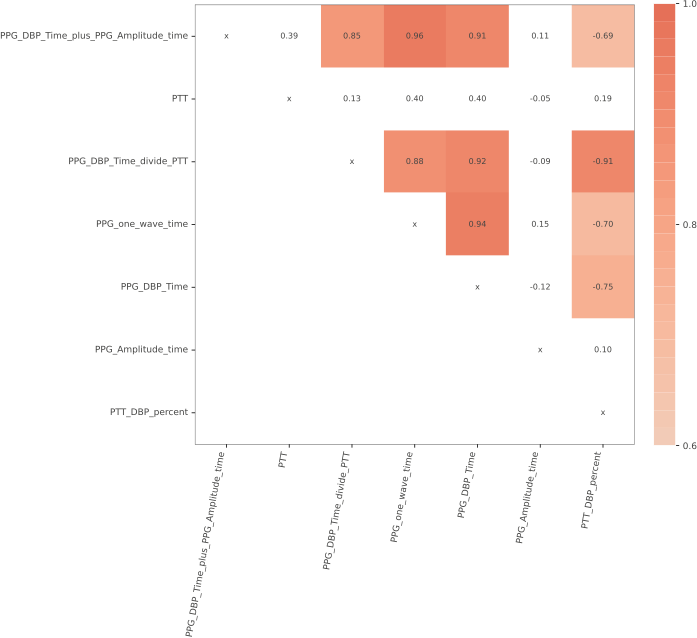

In [29]:
df_target = pd.DataFrame(df, columns=["SBP", "DBP"])
df.drop(["SBP", "DBP"], axis=1, inplace=True)
df_target.head()

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
folds = KFold(n_splits=10, shuffle=True)

# resplit the data after processing
x_train, x_test, y_train, y_test = train_test_split(df, df_target, test_size=0.3)

from rfpimp import plot_corr_heatmap
viz = plot_corr_heatmap(x_train,figsize=(10,10))
viz


MAE SBP: 2.2165582225600344 SD:3.329553530651926 MAE DBP: 1.1327624799922962 SD:14.043936398649398


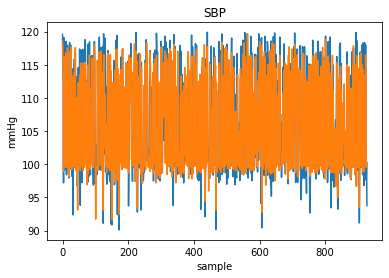

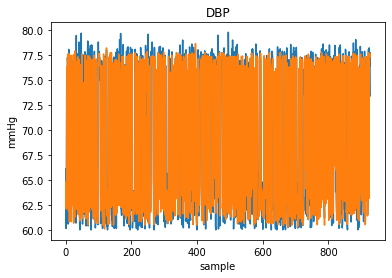

In [30]:
#####RandomForest Regressor#######
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt
regressor = RandomForestRegressor(n_estimators = 10) 
regressor.fit(x_train, y_train)
prediction = regressor.predict(x_test)

error_sbp = mean_absolute_error(prediction[:,0],y_test["SBP"].values)
error_dbp = mean_absolute_error(prediction[:,1],y_test["DBP"].values)

error_sbp_std = np.std(prediction[:,0] - y_test["SBP"].values)
error_dbp_std = np.std(prediction[:,1] - y_test["SBP"].values)

print(f"MAE SBP: {error_sbp} SD:{error_sbp_std} MAE DBP: {error_dbp} SD:{error_dbp_std}")

s = np.vstack(y_test["SBP"])
d = np.vstack(y_test["DBP"])

plt.figure(1)
plt.title("SBP")
plt.xlabel("sample") 
plt.ylabel("mmHg") 
plt.plot(s)
plt.plot(prediction[:,0])

plt.figure(2)
plt.title("DBP")
plt.xlabel("sample") 
plt.ylabel("mmHg") 
plt.plot(d)
plt.plot(prediction[:,1])

MAE SBP: 3.486903482063252 SD:4.612901439834253 MAE DBP: 4.282012482883148 SD:4.927590828805749


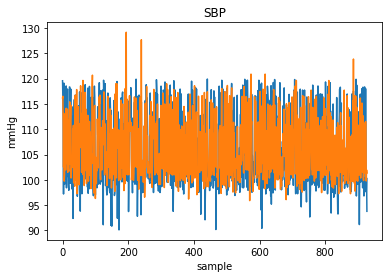

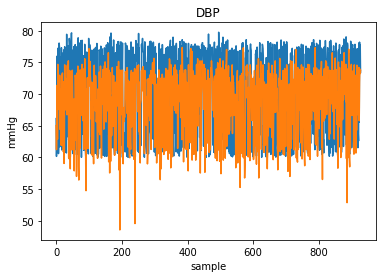

In [31]:
##############Linear Regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

linear = LinearRegression()
linear.fit(x_train, y_train)
prediction = linear.predict(x_test)

error_sbp = mean_absolute_error(prediction[:,0],y_test["SBP"].values)
error_dbp = mean_absolute_error(prediction[:,1],y_test["DBP"].values)

error_sbp_std = np.std(prediction[:,0] - y_test["SBP"].values)
error_dbp_std = np.std(prediction[:,1] - y_test["DBP"].values)

print(f"MAE SBP: {error_sbp} SD:{error_sbp_std} MAE DBP: {error_dbp} SD:{error_dbp_std}")

s = np.vstack(y_test["SBP"])
d = np.vstack(y_test["DBP"])

plt.figure(1)
plt.title("SBP")
plt.xlabel("sample") 
plt.ylabel("mmHg") 
plt.plot(s)
plt.plot(prediction[:,0])

plt.figure(2)
plt.title("DBP")
plt.xlabel("sample") 
plt.ylabel("mmHg") 
plt.plot(d)
plt.plot(prediction[:,1])